In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import cudf 
import cuml 

import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sentence_transformers import SentenceTransformer


pd.set_option('display.max_colwidth', 200)

from sklearn.model_selection import StratifiedKFold

import pickle

### Sentence Embedding

In [3]:
model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

rud_df = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
data = rud_df["txt"].values
embeddings = model.encode(data, show_progress_bar=True)
with open('../processed/rud_embeddings.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle)



Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

### Sentence Embedding (HDBSCAN)  

In [4]:
def score_hdbscan(cluster, prob_threshold = 0.05):
    
    cluster_labels = cluster.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(cluster_labels)
    cost = (np.count_nonzero(cluster.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost
 

def generate_cluster (embeddings, n_neighbors, n_components, min_cluster_size, random_state = 123):
    
    u = cuml.manifold.UMAP(n_neighbors=n_neighbors, n_components=n_components, verbose=0, random_state=random_state)
    umap_embeddings = u.fit_transform(embeddings)
    cluster = cuml.cluster.HDBSCAN(min_cluster_size = min_cluster_size, metric='euclidean', cluster_selection_method='eom', verbose=0)
    cluster.fit(umap_embeddings)
    
    return cluster

class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X


In [5]:
embeddings = pickle.load( open( "../processed/rud_embeddings.pickle", "rb" ) )

n_neighbors = 12
n_components = 2
min_cluster_size = 13


cluster = generate_cluster (embeddings, n_neighbors, n_components, min_cluster_size)


score_hdbscan (cluster)

Label prop iterations: 19
Label prop iterations: 10
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 2
Iterations: 5
3799,156,155,21,276,2051
Label prop iterations: 3
Iterations: 1
3335,50,44,7,58,742


(82, 0.30181569030489896)

In [6]:
rud_df["cluster"]=cluster.labels_
g = rud_df.groupby(["cluster"]).agg({"post_id":"count"}).sort_values(by="post_id", ascending=False).reset_index()
g

,cluster,post_id
0,-1,1761
1,56,695
2,9,291
3,33,215
4,57,149
...,...,...
77,75,16
78,67,16
79,37,15
80,26,14


In [7]:
rud_cluster = rud_df.groupby(['cluster'], as_index = False).agg({'txt': ' '.join, 'post_id':'count'})

    
count_vectorizer = CountVectorizer(stop_words="english", ngram_range=(1,3), max_df=0.5).fit(rud_cluster["txt"])
count = count_vectorizer.transform(rud_cluster["txt"])
words = count_vectorizer.get_feature_names()

# Create c-TF-IDF
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(rud_cluster))


In [8]:
def topic_words (index, n_words=5):
    x = ctfidf[index].toarray()
    indices = x[0,:].argsort()[-n_words:]
    return [words[i] for i in indices] 

stats = rud_df.query("cluster > -1").groupby(["cluster"]).agg({"txt":"count"}).reset_index()

df =stats.sort_values(by="txt", ascending=False).copy()

df["topic"] = df["cluster"].map(lambda x: topic_words(x+1) )

c = rud_df.groupby(["cluster"]).agg({"post_id":"count", "offensiveness_score":"mean"}).reset_index()
c = c.sort_values(by="offensiveness_score", ascending = False)
c

,cluster,post_id,offensiveness_score
42,41,48,0.242813
23,22,20,0.230350
39,38,19,0.219053
65,64,23,0.191174
17,16,52,0.189385
...,...,...,...
9,8,22,-0.277409
5,4,49,-0.278898
77,76,17,-0.289059
81,80,30,-0.300167


In [9]:
for i, x in enumerate ( c.index [:20] ):
    w = topic_words(x+1) 
    print (f"cluster:{x},  offensiveness_score:{c['offensiveness_score'].values[i]:.5}, topic:{w}" )

cluster:42,  offensiveness_score:0.24281, topic:['rape', 'rapes', 'prison rape', 'prison', 'prisons']
cluster:23,  offensiveness_score:0.23035, topic:['porn', 'boys', 'scouting', 'scout', 'scouts']
cluster:39,  offensiveness_score:0.21905, topic:['pairs bed waiting', 'tone dude', 'family friendly', 'tchk', 'chair']
cluster:65,  offensiveness_score:0.19117, topic:['banned words', 'yevgeny prigozhin', 'left trying', 'yevgeny', 'russia']
cluster:17,  offensiveness_score:0.18938, topic:['neutral', 'restroom', 'gender neutral', 'bathroom', 'bathrooms']
cluster:50,  offensiveness_score:0.18332, topic:['murdered', 'cartel', 'entire town', 'commodus', 'algae']
cluster:47,  offensiveness_score:0.17139, topic:['bargain', 'fast traveled public', 'nickel time', 'fast traveled', 'wait guys']
cluster:12,  offensiveness_score:0.16895, topic:['drop', 'string', 'album', 'song', 'songs']
cluster:59,  offensiveness_score:0.15359, topic:['meps', 'active', '15t', 'woft', 'waiver']
cluster:45,  offensivenes

In [10]:
u = cuml.manifold.UMAP(n_neighbors=13, n_components=2, verbose=0, random_state=123)
umap_embeddings = u.fit_transform(embeddings)

In [11]:
rud_df["umap0"] = umap_embeddings[:,0]
rud_df["umap1"] = umap_embeddings[:,1]

### Build pairs

[]

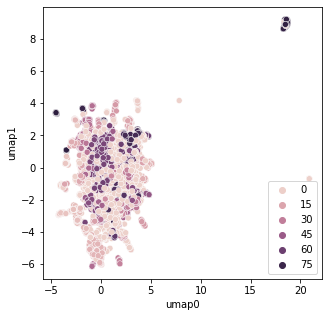

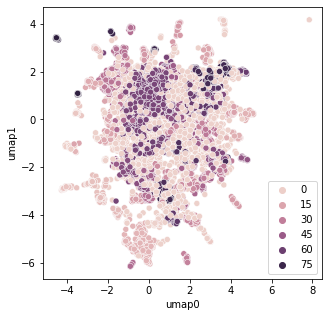

In [12]:
plt.figure(figsize=(5,5))
sns.scatterplot ( x=rud_df["umap0"], y=rud_df["umap1"], hue=rud_df["cluster"].values )
plt.plot()


rud_df = rud_df.query("umap0 < 10.0").reset_index(drop=True)


plt.figure(figsize=(5,5))
sns.scatterplot ( x=rud_df["umap0"], y=rud_df["umap1"], hue=rud_df["cluster"].values )
plt.plot()


In [13]:
BINS = 15

rud_df["y"] = pd.cut(rud_df["offensiveness_score"], bins=BINS, labels=False)
rud_df.groupby("y").agg({"offensiveness_score":("min","max"), "post_id":"count"}).reset_index()

y offensiveness_score        post_id
                       min    max   count
0    0              -0.889 -0.766      18
1    1              -0.761 -0.644      68
2    2              -0.638 -0.521     234
3    3              -0.511 -0.391     414
4    4              -0.383 -0.267     683
5    5              -0.261 -0.146     888
6    6              -0.140 -0.021     940
7    7               0.000  0.106     783
8    8               0.109  0.229     558
9    9               0.234  0.356     367
10  10               0.362  0.479     246
11  11               0.489  0.604     204
12  12               0.609  0.729     156
13  13               0.739  0.854     115
14  14               0.867  0.979      34

In [14]:
rud_df.head()

,post_id,comment_id,txt,url,offensiveness_score,cluster,umap0,umap1,y
0,42g75o,cza1q49,"> The difference in average earnings between men and women can be explained by taking into account relevant factors.\n\nSo it isn't a myth, you just feel that you can explain it.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza1q49/,-0.083,69,0.858396,-2.929386,6
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based on the sex of the person.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza1wdh/,-0.022,69,0.414504,-2.943434,6
2,42g75o,cza2bw8,"The assertion is that women get paid less for the *same* jobs, and that they get paid less *because* they are women.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2bw8/,-0.146,69,0.806515,-2.830811,5
3,42g75o,cza2iji,"You said in the OP that's not what they're measuring. They're measuring aggregate. \n\nAs entertainers, women make less. Isn't that what JLaw was complaining about?",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2iji/,-0.083,69,0.894984,-2.864346,6
4,42g75o,cza2jj3,">Men and women are not payed less for the same job\n\nI don't think many people say this is the case though. I think this is a misconception on the other side, not something feminists have said. E...",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2jj3/,-0.042,69,0.863091,-2.906368,6


In [15]:
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, random_state=123, shuffle=True)
y = rud_df["y"].astype(str) + "_" + rud_df["cluster"].astype (str)
rud_df["kfold"] = -1

for f, (t_, v_) in enumerate(kf.split(X=rud_df, y=y)):
    rud_df.loc[v_, 'kfold'] = f

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [16]:
less_toxic = []
more_toxic = []
less_toxic_class = []
more_toxic_class = []
kfold = []


for i in tqdm(range (BINS)):
    for fold in range(NFOLDS):
        ids_i = rud_df.query("y == @i and kfold == @fold")["comment_id"].values
        for j in range (BINS):
            if j in ( i + 2, i +3 , i + 4, i + 5,  i + 6 ):
                ids_j = rud_df.query("y == @j and kfold == @fold")["comment_id"].values
                for id_i in ids_i:
                    for id_j in ids_j:
                        less_toxic.append(id_i)
                        less_toxic_class.append(i)
                        more_toxic.append(id_j)
                        more_toxic_class.append (j)
                        kfold.append(fold)

df = pd.DataFrame({"kfold":kfold,
                    "less_toxic_id":less_toxic, 
                   "more_toxic_id":more_toxic,
                   "less_toxic_class": less_toxic_class,
                   "more_toxic_class": more_toxic_class,
                  })

print(f"df:{len(df)}")
df["delta"] = df["more_toxic_class"] - df["less_toxic_class"]
df.to_csv("../processed/rud_pair.csv", index=False)
df.head()

  0%|          | 0/15 [00:00<?, ?it/s]

df:1915323


,kfold,less_toxic_id,more_toxic_id,less_toxic_class,more_toxic_class,delta
0,0,e35vwp5,d4zj4tw,0,2,2
1,0,e35vwp5,e7wp1an,0,2,2
2,0,e35vwp5,e9e83z7,0,2,2
3,0,e35vwp5,efo7c67,0,2,2
4,0,e35vwp5,efza83f,0,2,2


In [17]:
df.groupby("kfold").agg({"less_toxic_id":"count"})

,less_toxic_id
kfold,
0,382589
1,384606
2,384844
3,382160
4,381124


In [18]:
df["delta"].value_counts()

2    597597
3    484986
4    370557
5    270640
6    191543
Name: delta, dtype: int64

In [19]:
df.groupby(["less_toxic_class","more_toxic_class"]).agg({"less_toxic_id":"count"})

less_toxic_id
less_toxic_class more_toxic_class               
0                2                           839
                 3                          1491
                 4                          2470
                 5                          3193
                 6                          3387
1                3                          5628
                 4                          9267
                 5                         12088
                 6                         12778
                 7                         10643
2                4                         31943
                 5                         41580
                 6                         43985
                 7                         36644
                 8                         26122
3                5                         73541
                 6                         77836
                 7                         64816
                 8                         46201
                 9                         30407
4                6                        128409
                 7                        106971
                 8                         76203
                 9                         50081
                 10                        33626
5                7                        139037
                 8                         99116
                 9                         65230
                 10                        43664
                 11                        36212
6                8                        104893
                 9                         68985
                 10                        46271
                 11                        38347
                 12                        29339
7                9                         57445
                 10                        38519
                 11                        31969
                 12                        24414
                 13                        18021
8                10                        27431
                 11                        22778
                 12                        17390
                 13                        12845
                 14                         3786
9                11                        14960
                 12                        11417
                 13                         8445
                 14                         2473
10               12                         7693
                 13                         5639
                 14                         1690
11               13                         4714
                 14                         1387
12               14                         1064

In [20]:
rud_df = rud_df[["comment_id","txt", "offensiveness_score", "cluster", "kfold"]].rename(columns={"txt":"text"})
rud_df.to_csv("../processed/rud_text.csv", index=False)